<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/text_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key Words & Documents Clusters

Open-source based set of capabilities allowing to analyze text datasets.  Currently Implemented Functionality:
1. Key words indentification for a text corpus (YAKE algorithm)
2. Key words identification for each document in the corpus (YAKE algorithms)
3. Basic sentiment analysis (currently using Sienbert or J-Hartman models from the Huggingface Hub)
4. Advanced Sentiment analysis & text classification (Using SetFit model with few shot training)
5. Semantic Search & Clustering (Approximate Nearest Neighbours, ANNOY package)
6. Basic vizualization (UMAP or PCA for dimensionality reduction, Altair or Matplotlib for plotting)

**Work in Progress!**

In [1]:
import pandas as pd

In [2]:
%%capture
!pip install ipywidgets

In [3]:
import ipywidgets as widgets
from IPython.display import display
layout = widgets.Layout(width='auto', height='40px')

In [4]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving beer_5k.csv to beer_5k.csv


In [5]:
# Dataframe processing (CSV format is expected, minimal text pre-processing at the moment (write you own if you needed it :) ), change the file name as needed)
df = pd.read_csv('beer_5k.csv')

In [6]:
#Widget to pick the number of documents to process
style = {'description_width': 'initial'}
box = widgets.BoundedIntText(
    min=1,
    max=df.shape[0],
    step=10,
    description='# of docs to process:',
    value=df.shape[0],
    style = style
)
display(box)

BoundedIntText(value=4999, description='# of docs to process:', max=4999, min=1, step=10, style=DescriptionSty…

In [7]:
texts = [item.replace("\t", " ")[:box.value] for item in df['text'] [:box.value]]
#df.head(2)

In [8]:
#above code wrapped in a function
def text_input(file = 'beer_5k.csv'):
  df = pd.read_csv(file)
  texts = [item.replace("\t", " ") for item in df['text']]
  return texts

In [ ]:
texts_acct = text_input('accnt_issues.csv')

In [9]:
#Create a single blob of text
corpus = ' '.join(texts)

In [14]:
corpus_acct = ' '.join(texts_acct)

Keywords

In [10]:
%%capture
!pip install yake

In [11]:
import yake

In [12]:
# YAKE Config
kw_extractor = yake.KeywordExtractor()
language = 'en'
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 50

In [13]:
#Keyword for the corpus
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(corpus)
keywords

[('head', 0.0002999954807086001),
 ('white head', 0.00030283078816108807),
 ('hops', 0.0003752855313968149),
 ('Nice', 0.0004467750112788856),
 ('pours', 0.000496275880448961),
 ('malt', 0.0005361782136829841),
 ('IPA', 0.0005397444143146),
 ('hop', 0.0005534164518294044),
 ('beer', 0.000565631055474805),
 ('Pale Ale', 0.0006210626259602961),
 ('good', 0.0006224029378651028),
 ('light', 0.000710041796367628),
 ('citrus', 0.0008304431235782483),
 ('hop aroma', 0.0008486200195130992),
 ('Poured', 0.0008927204180238064),
 ('Citrus hops', 0.0009808761472823997),
 ('aroma', 0.0010336525980771285),
 ('taste', 0.001062330343957436),
 ('pale', 0.0010837402703984594),
 ('orange', 0.0011013558615285387),
 ('beer pours', 0.001176383700046216),
 ('Caldera IPA', 0.0012096106924508138),
 ('caramel malt', 0.00127877499441309),
 ('flavor', 0.0013432987684357338),
 ('lacing', 0.0013791989676920021),
 ('color', 0.0014472894321920762),
 ('hop flavor', 0.001448196123654343),
 ('White', 0.00152773486432519

In [14]:
#Keyword for the individual documents
custom_kw_extractor_docs = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=10, features=None)

In [15]:
#Distilling each document to a set of keywords
distilled_docs = []
for item in texts:
  keywords = custom_kw_extractor_docs.extract_keywords(item)
  tmp = [item[0] for item in keywords]
  distilled_docs.append(tmp)

In [ ]:
#test print
distilled_docs[30:40]

Data for a classifier POC

In [ ]:
ipa_class = []
for ind, item in enumerate(distilled_docs):
  if 'IPA' in item:
    ipa_class.append((ind,item))

In [ ]:
#test print
ipa_class[10]

(346,
 ['Reviewed',
  'Decent IPA',
  'hops',
  'citrus',
  'bitter',
  'IPA',
  'off-white head',
  'Pours',
  'head',
  'Aroma'])

In [ ]:
other = []
for ind, item in enumerate(distilled_docs):
  if 'IPA' not in item:
    other.append((ind,item))

Dicts to be used for classification finetuning & sentiment analysis using SetFit Model

In [ ]:
texts_IPA = []
for item in ipa_class:
  texts_IPA.append(texts[item[0]])

In [ ]:
dict_IPA = {'idx': [item for item in range(len(texts_IPA))], 'sentence': texts_IPA, 'label': [0]*len(texts_IPA)}

In [ ]:
texts_other = []
for item in other[:170]:
  texts_other.append(texts[item[0]])

In [ ]:
dict_other = {'idx': [item for item in range(len(texts_other))], 'sentence': texts_other, 'label': [1]*len(texts_other)}

In [ ]:
dict_train = {'idx': [item for item in range(len(texts_other))]+[item for item in range(len(texts_IPA))], 
              'sentence': texts_other+texts_IPA, 'label': [1]*len(texts_other)+[0]*len(texts_IPA)}

In [ ]:
dataset_train = Dataset.from_dict(dict_train)
dataset_train_few = dataset_train.shuffle(seed = 42).select(range(16))

In [ ]:
for i in range(10):
  print(dataset_train_few[i])

In [ ]:
#dataset for the sentiment analysis POC
dict_sentiment = {'idx':list(range(4)), "text":texts[:4]}
dataset_sentiment = Dataset.from_dict(dict_sentiment)

In [ ]:
dataset_sentiment = Dataset.from_dict(dict_sentiment)

Embeddings for Documents & document distilled to a list of concepts

In [16]:
%%capture
!pip install -U sentence-transformers

In [17]:
%%capture
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')
model.max_seq_length = 300

In [ ]:
#Embedding Demo code
#Compute embedding 
embeddings1 = model.encode([texts[0]], convert_to_tensor=True)
embeddings2 = model.encode([' '.join(distilled_docs[0])], convert_to_tensor=True)

#Compute cosine-similarities
cosine_score = util.cos_sim(embeddings1, embeddings2)

In [ ]:
embeddings1 = model.encode([texts[5]], convert_to_tensor=True)
cosine_score = util.cos_sim(embeddings1, embeddings2)

In [ ]:
cosine_score

tensor([[0.2841]], device='cuda:0')

In [ ]:
cosine_score

tensor([[0.6680]], device='cuda:0')

In [18]:
# Embeddings for Distilled Docs
emb_distilled_input = [' '.join(item) for item in distilled_docs]
emb_distilled = model.encode(emb_distilled_input)

In [19]:
# Embeddings for Original Docs
emb_texts = model.encode(texts)

Clusterning using ANNOY Package (Approximate K-nearest neighbours)

In [ ]:
!pip install annoy

In [ ]:
from annoy import AnnoyIndex

In [ ]:
#Template Code
# Create the search index, pass the size of embedding
search_index = AnnoyIndex(768, 'angular')
# Add all the vectors to the search index
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])

search_index.build(10) # 10 trees
#search_index.save('askhn.ann')

In [ ]:
#More Template Code
# Choose an example (we'll retrieve others similar to it)
example_id = 50

# Retrieve nearest neighbors
similar_item_ids = search_index.get_nns_by_item(example_id,
                                                10, # Number of results to retrieve
                                                include_distances=True)
# Format and print the text and distances
results = pd.DataFrame(data={'post titles': texts[similar_item_ids[0]], 
                             'distance': similar_item_ids[1]}).drop(example_id)

#print(f"Query post:'{df.iloc[example_id]['title']}'\nNearest neighbors:")
results

SetFit Model (Idea: a classifier tuned up for a given dataset (8 examples per class))

In [ ]:
%%capture
!pip install setfit
!pip install datasets

In [ ]:
from datasets import Dataset, load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

In [ ]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset_train_few,
    eval_dataset=dataset_train,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [ ]:
trainer.train()
#metrics = trainer.evaluate()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 640
  Num epochs = 1
  Total optimization steps = 40
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
metrics = trainer.evaluate()

Applying column mapping to evaluation dataset
***** Running evaluation *****


In [ ]:
metrics

{'accuracy': 0.9670658682634731}

In [ ]:
# Push model to the Hub
#trainer.push_to_hub("my-awesome-setfit-model")

# Download from Hub and run inference
#model = SetFitModel.from_pretrained("lewtun/my-awesome-setfit-model")
# Run inference
preds = trainer.model.predict(["Pours a clear deep orange with a thick off-white head. Aroma of piney, grassy hops, some citrus and tropical fruits. Flavor of caramel malt and light citrus upfront with a bitter hops finish. Decent IPA, rather on the bitter side."])

Basic Sentiment Analysis

In [ ]:
%%capture
!pip install transformers
!pip install datasets

In [ ]:
from datasets import Dataset
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

In [ ]:
%%capture
#pipe = pipeline("sentiment-analysis",  model="j-hartmann/sentiment-roberta-large-english-3-classes", return_all_scores=True, device=0)
pipe = pipeline("sentiment-analysis",  model="siebert/sentiment-roberta-large-english", return_all_scores=True, device=0)

In [ ]:
# KeyDataset (only *pt*) will simply return the item in the dict returned by the dataset item
# as we're not interested in the *target* part of the dataset. For sentence pair use KeyPairDataset
for out in tqdm(pipe(KeyDataset(dataset_sentiment, "text"), batch_size=4, truncation="longest_first")): #May or maynot need tto use Key Dataset
    print(out)

  0%|          | 0/1 [00:00<?, ?it/s]

[{'label': 'NEGATIVE', 'score': 0.9994102716445923}, {'label': 'POSITIVE', 'score': 0.0005896911025047302}]
[{'label': 'NEGATIVE', 'score': 0.005144994240254164}, {'label': 'POSITIVE', 'score': 0.9948549270629883}]
[{'label': 'NEGATIVE', 'score': 0.0012539081508293748}, {'label': 'POSITIVE', 'score': 0.9987460374832153}]
[{'label': 'NEGATIVE', 'score': 0.0012314756168052554}, {'label': 'POSITIVE', 'score': 0.9987685084342957}]


Vizualisation Using Altair & UMAP for dimensionality reduction

In [20]:
%%capture
!pip install altair
!pip install umap-learn

In [21]:
import umap.umap_ as umap
import altair as alt

In [22]:
reducer = umap.UMAP(n_neighbors=20,n_components=2) 
umap_embeds = reducer.fit_transform(emb_texts)

In [23]:
distilled_texts = [' '.join(item) for item in distilled_docs]

In [28]:
#Widget to pick the documents that you want to display in a different color
selector = widgets.Textarea(
                            value='Select a keyword to interest',
                            placeholder='Type a key word you want to select documents by',
                            description='String:',
                            disabled=False
                            )
display(selector)

Textarea(value='Select a keyword to interest', description='String:', placeholder='Type a key word you want to…

In [29]:
selector.value

'Caldera'

In [30]:
#creating groupings to be colored by a different color
text_search=[True if item.find(selector.value) != -1 else False for item in distilled_texts]

In [31]:
# Prepare the data to plot and interactive visualization
# using Altair
df_explore = pd.DataFrame(data={'text': distilled_texts, 'groups':text_search})
df_explore['x'] = umap_embeds[:,0]
df_explore['y'] = umap_embeds[:,1]

# Plot
chart = alt.Chart(df_explore).mark_circle(size=60).encode(
    x=alt.X('x',scale=alt.Scale(zero=False)),
    y=alt.Y('y',scale=alt.Scale(zero=False)),
    tooltip=['text'],
    color=alt.condition(alt.datum.groups == True, alt.value('red'),alt.value('blue'))
).properties(
    width=700,
    height=400
)
chart.interactive()

alt.Chart(...)

In [34]:
# visualization code - UMAP - 3D
import matplotlib.pyplot as plt
%matplotlib inline
def UMAP_plot_3D(emb):
  reducer = umap.UMAP(n_neighbors=20,n_components=3) 
  principal_comp = reducer.fit_transform(emb)

  x = []
  y = []
  z = []
  for value in principal_comp:
    x.append(value[0])
    y.append(value[1])
    z.append(value[2])
        
  plt.figure(figsize=(16, 16)) 
  # Creating figure
  fig = plt.figure(figsize = (16, 16))
  ax = plt.axes(projection ="3d")
  
  # Creating plot
  ax.scatter3D(x, y, z, color = "blue")
  plt.title("simple 3D scatter plot")

  plt.show()

<Figure size 1152x1152 with 0 Axes>

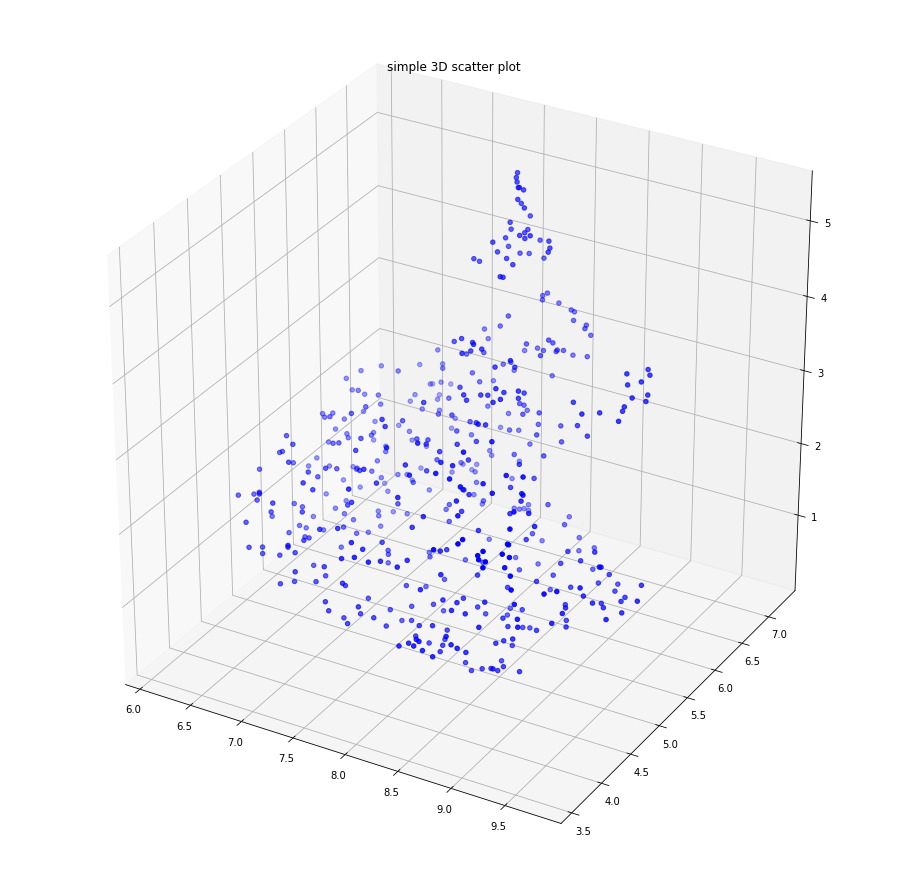

In [36]:
UMAP_plot_3D(emb_texts)

SetFit Model - Neural Compression

In [ ]:
from transformers import pipeline
%%capture
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
!pip install setfit neural_compressor optimum[onnxruntime]==1.5.0 onnxruntime_extensions

# Useful Code Snippets

Utilities

In [ ]:
import pprint
pp = pprint.PrettyPrinter(width = 80)

In [ ]:
pp.pprint(texts[:4])

['A lot of foam. But a lot. In the smell some banana, and then lactic and '
 'tart. Not a good start. Quite dark orange in color, with a lively '
 'carbonation (now visible, under the foam). Again tending to lactic sourness. '
 'Same for the taste. With some yeast and banana.',
 'Dark red color, light beige foam, average. In the smell malt and caramel, '
 'not really light. Again malt and caramel in the taste, not bad in the end. '
 'Maybe a note of honey in teh back, and a light fruitiness. Average body. In '
 'the aftertaste a light bitterness, with the malt and red fruit. Nothing '
 'exceptional, but not bad, drinkable beer.',
 'Almost totally black. Beige foam, quite compact, not bad. Light smell, just '
 'a bit of roast, and some hop. A bit too light. The taste is light oo, and '
 'drinkable, with some malt, roast, hints of coffee. Nothing exceptional, but '
 'after all drinkable and pleasant. Light to average body. In the aftertaste '
 'some dust, somr roast, hint of caramel, and

Visualization

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# visualization code - PCA
from sklearn.decomposition import PCA
def PCA_plot(emb):
  pca = PCA(n_components=2)
  #Creates and PCA model and plots it
  principal_comp = pca.fit_transform(emb)

  x = []
  y = []
  for value in principal_comp:
    x.append(value[0])
    y.append(value[1])
        
  plt.figure(figsize=(16, 16)) 
  #Outputting all the embeddings
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
  plt.show()

In [33]:
# visualization code - PCA - 3D
from sklearn.decomposition import PCA
def PCA_plot_3D(emb):
  pca = PCA(n_components=3)
  #Creates and PCA model and plots it
  principal_comp = pca.fit_transform(emb)

  x = []
  y = []
  z = []
  for value in principal_comp:
    x.append(value[0])
    y.append(value[1])
    z.append(value[2])
        
  plt.figure(figsize=(16, 16)) 
  # Creating figure
  fig = plt.figure(figsize = (16, 16))
  ax = plt.axes(projection ="3d")
  
  # Creating plot
  ax.scatter3D(x, y, z, color = "blue")
  plt.title("simple 3D scatter plot")

  #Outputting all the embeddings
  #for i in range(len(x)):
    #plt.scatter(x[i],y[i])
  plt.show()

<Figure size 1152x1152 with 0 Axes>

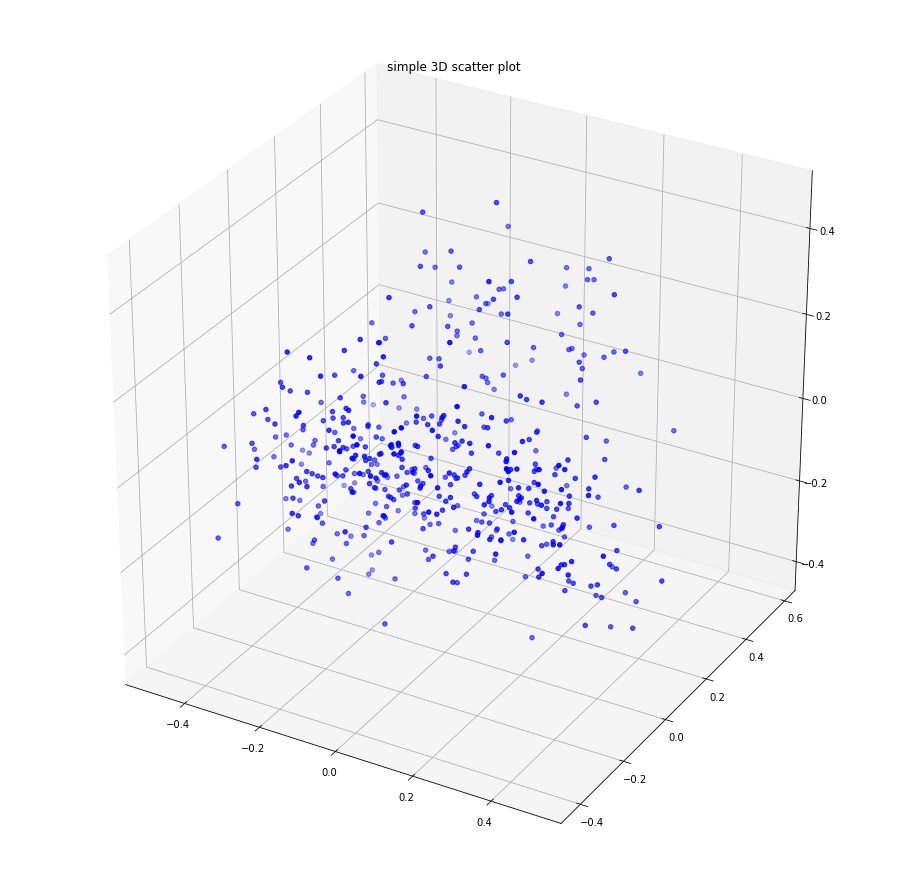

In [34]:
PCA_plot_3D(emb_distilled)

SetFit test code using Hugginface Datasets

In [ ]:
# Load a dataset from the Hugging Face Hub
dataset = load_dataset("sst2")

# Simulate the few-shot regime by sampling 8 examples per class
num_classes = 2
train_dataset = dataset["train"].shuffle(seed=42).select(range(8 * num_classes))
eval_dataset = dataset["validation"]

In [ ]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [ ]:
# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

In [ ]:
metrics

{'accuracy': 0.6559633027522935}

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
dataset = [
    "I enjoy reading about Machine Learning and Machine Learning is my PhD subject",
    "I would enjoy a walk in the park",
    "I was reading in the library"
]

In [ ]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

spaCY

In [ ]:
import spacy 
from spacy.language import Language 

In [ ]:
# text processing      
nlp = spacy.load('en_core_web_sm')        
#df['Tokens'] = df.Sumcription.apply(lambda x: nlp(x))    
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS        
#spacy_stopwords.add('attach')
#df['Lema_Token']  = df.Tokens.apply(lambda x: " ".join([token.lemma_ for token in x if token not in spacy_stopwords]))

In [ ]:
@Language.component("info_component")
def my_component(doc):
    #print(f"After tokenization, this doc has {len(doc)} tokens.")
    print("The lemmatized tokens are:", [token.lemma_ for token in doc])
    return doc

nlp = spacy.load("en_core_web_sm", disable = ['ner'])
pipeline = ["tok2vec", "parser", "lemmatizer"]

nlp.add_pipe("info_component", name="print_info",last=True)
print(nlp.pipe_names)  # ['tagger', 'parser', 'ner', 'print_info']
doc = nlp("This is a sentence.")

In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
tokens = [token.lemma_ for token in doc if token.lemma_ not in spacy_stopwords and not token.is_punct]  

In [ ]:
#tensors
vectors = [item.tensor for item in doc]
# not lemmatized tokens
tokens = [item.text for item in doc]

In [ ]:
# NLP Pipelien
nlp = spacy.load("en_core_web_sm")
doc = nlp("This is a sentence.")
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [ ]:
for doc in nlp.pipe(texts[:20]):
  print(doc.ents)

In [ ]:
texts_spacy = []
for doc in nlp.pipe(texts[:3000]):
  tokens = [token.lemma_ for token in doc if token.lemma_ not in spacy_stopwords and not token.is_punct]

  texts_spacy.append(' '.join(tokens))

In [ ]:
texts_spacy_texts = []
for doc in nlp.pipe(texts[:3000]):
  tokens = [token.text for token in doc if token.text not in spacy_stopwords and not token.is_punct]
  texts_spacy_texts.append(' '.join(tokens))

In [ ]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(texts[:3000])
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(50))

Rake-NLTK

In [ ]:
%%capture
!pip install rake_nltk

In [ ]:
from rake_nltk import Rake
import nltk
%%capture
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
rake_nltk_var = Rake(include_repeated_phrases=False, min_length=1, max_length=3)
rake_nltk_var.extract_keywords_from_text(long_text)
keyword_extracted = rake_nltk_var.get_ranked_phrases_with_scores()
#print(keyword_extracted)

Higging Face SetFit training block (alternative to the above)

In [ ]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    use_differentiable_head=True,
    head_params={"out_features": num_classes},
)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"sentence": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.freeze() # Freeze the head
trainer.train() # Train only the body

# Unfreeze the head and freeze the body -> head-only training
trainer.unfreeze(keep_body_frozen=True)
# or
# Unfreeze the head and unfreeze the body -> end-to-end training
trainer.unfreeze(keep_body_frozen=False)

trainer.train(
    num_epochs=25, # The number of epochs to train the head or the whole model (body and head)
    batch_size=16,
    body_learning_rate=1e-5, # The body's learning rate
    learning_rate=1e-2, # The head's learning rate
    l2_weight=0.0, # Weight decay on **both** the body and head. If `None`, will use 0.01.
)
metrics = trainer.evaluate()

# Push model to the Hub
trainer.push_to_hub("my-awesome-setfit-model")

# Download from Hub and run inference
model = SetFitModel.from_pretrained("lewtun/my-awesome-setfit-model")
# Run inference
preds = model(["i loved the spiderman movie!", "pineapple on pizza is the worst 🤮"]) 